### **1. Download the dataset**

In [ ]:
import requests
import pathlib

def download(type = "val"):
    todownload = [
        "L1C_B1", "L1C_B2", "L1C_B3", "L1C_B4", "L1C_B5", 
        "L1C_B6", "L1C_B7", "L1C_B8", "L1C_B8A", "L1C_B9", 
        "L1C_B10", "L1C_B11", "L1C_B12", "LABEL_manual_hq"
    ]

    hfroot = f"https://huggingface.co/datasets/csaybar/CloudSEN12-high/resolve/main/{type}/"
    pathlib.Path(f"{type}/").mkdir(exist_ok=True, parents=True)

    for band in todownload:
        band_link = hfroot + band + ".dat"
        with requests.get(band_link) as r:
            with open(f"{type}/{band}.dat", "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

    return True

In [ ]:
download(type = "val")
download(type = "test")

True

### **2. Create the dataloader**

In [ ]:
# Create dataloader
import torch
import numpy as np

def load_data(path_root = "val", shape=(535, 512, 512)):
    return {
        "B1": np.memmap(path_root / "L1C_B1.dat", dtype=np.int16, mode="r", shape=shape),
        "B2": np.memmap(path_root / "L1C_B2.dat", dtype=np.int16, mode="r", shape=shape),
        "B3": np.memmap(path_root / "L1C_B3.dat", dtype=np.int16, mode="r", shape=shape),
        "B4": np.memmap(path_root / "L1C_B4.dat", dtype=np.int16, mode="r", shape=shape),
        "B5": np.memmap(path_root / "L1C_B5.dat", dtype=np.int16, mode="r", shape=shape),
        "B6": np.memmap(path_root / "L1C_B6.dat", dtype=np.int16, mode="r", shape=shape),
        "B7": np.memmap(path_root / "L1C_B7.dat", dtype=np.int16, mode="r", shape=shape),
        "B8": np.memmap(path_root / "L1C_B8.dat", dtype=np.int16, mode="r", shape=shape),
        "B8A": np.memmap(path_root / "L1C_B8A.dat", dtype=np.int16, mode="r", shape=shape),
        "B9": np.memmap(path_root / "L1C_B9.dat", dtype=np.int16, mode="r", shape=shape),
        "B10": np.memmap(path_root / "L1C_B10.dat", dtype=np.int16, mode="r", shape=shape),
        "B11": np.memmap(path_root / "L1C_B11.dat", dtype=np.int16, mode="r", shape=shape),
        "B12": np.memmap(path_root / "L1C_B12.dat", dtype=np.int16, mode="r", shape=shape),
        "target": np.memmap(path_root / "LABEL_manual_hq.dat", dtype=np.int8, mode="r", shape=shape)
    }

class CloudDataset(torch.utils.data.Dataset):
    def __init__(self, root, shape):
        self.root = pathlib.Path(root)
        self.data = load_data(self.root, shape)
    def __len__(self):
        return self.data["B1"].shape[0]

    def __getitem__(self, index):
        X = (
            self.data["B1"][index],
            self.data["B2"][index],
            self.data["B3"][index],
            self.data["B4"][index],
            self.data["B5"][index],
            self.data["B6"][index],
            self.data["B7"][index],
            self.data["B8"][index],
            self.data["B8A"][index],
            self.data["B9"][index],
            self.data["B10"][index],
            self.data["B11"][index],
            self.data["B12"][index]
        )
        # Concatenate the bands
        X = np.stack(X, axis=0)/10000        
        y = self.data["target"][index]
        
        return torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.LongTensor)

traindb = CloudDataset(root="test", shape=(975, 512, 512))
valdb = CloudDataset(root="val", shape=(535, 512, 512))

### **3. Viz results**

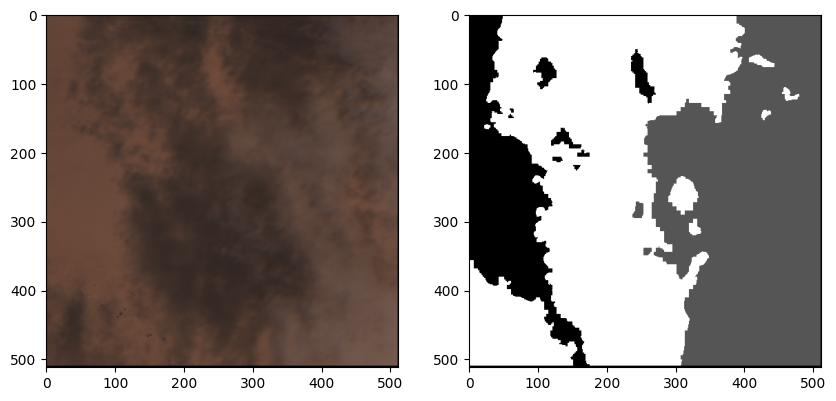

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
X, y = traindb[20]
ax[0].imshow(torch.moveaxis(X[[3, 2, 1]], 0, 2))
ax[1].imshow(y, cmap="gray")

### **4. Model**

In [ ]:
!pip install segmentation_models_pytorch
!pip install torchinfo

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=13,
    classes=4
)
model = model.cuda()

In [ ]:
import torchinfo
torchinfo.summary(model, input_size=(1, 13, 256, 256))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [1, 4, 256, 256]          --
├─MobileNetV2Encoder: 1-1                               [1, 13, 256, 256]         --
│    └─Sequential: 2-1                                  --                        --
│    │    └─Conv2dNormActivation: 3-1                   [1, 32, 128, 128]         3,808
│    │    └─InvertedResidual: 3-2                       [1, 16, 128, 128]         896
│    │    └─InvertedResidual: 3-3                       [1, 24, 64, 64]           5,136
│    │    └─InvertedResidual: 3-4                       [1, 24, 64, 64]           8,832
│    │    └─InvertedResidual: 3-5                       [1, 32, 32, 32]           10,000
│    │    └─InvertedResidual: 3-6                       [1, 32, 32, 32]           14,848
│    │    └─InvertedResidual: 3-7                       [1, 32, 32, 32]           14,848
│    │    └─InvertedResidual: 3-8     

### **5. Loss and Optimizer function**

In [ ]:
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **5. Train a model using torch**

In [ ]:
val_results = list()
for epoch in range(10):
    # Create datasets
    train_loader = torch.utils.data.DataLoader(traindb, batch_size=4, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valdb, batch_size=4, shuffle=False)
    
    # Train using the dataloader    
    for i, (X, y) in enumerate(train_loader):
      
        # Forward pass
        y_pred = model(X.cuda())

        # Compute loss
        loss = loss_fun(y_pred, y.cuda())

        # Compute gradients
        loss.backward()

        # Update weights
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()

        # Print loss
        if i % 10 == 0:
            print(f"Epoch {epoch}, batch {i}: {loss.item()}")
    
    # Validate
    val_container = list()
    for i, (X, y) in enumerate(val_loader):
        
        # Forward pass
        with torch.no_grad():
          y_pred = model(X.cuda())
          
          # Compute loss
          loss = loss_fun(y_pred, y.cuda())
          val_container.append(loss)          

        # Print loss
        print(f"Epoch {epoch}, batch {i}: {loss.item()}")
    result = float(torch.stack(val_container).mean().detach().cpu().numpy())        
    val_results.append(result)

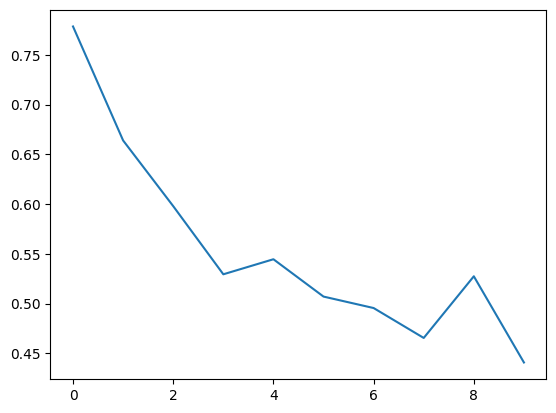

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_results)

## **6. Save the model**

In [ ]:
torch.save(model.state_dict(), "model.pt")

## **7. Make a prediction**

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=13,
    classes=4
)

4

In [ ]:
model.load_state_dict(torch.load('model.pt'))
model = model.eval()

In [ ]:
# Una imagen satelital de 1x13x512x512 -> Mostrame un map binario
# 1. Leer esa imagen satelital con rasterio
# 2. Utilizar el modelo entrenado para hacer una prediccion 1x13x512x512
# 3. Pasar el resultado de torch a numpy. 
# 4. Utilizar np.argmax 4x512x512 -> 512x512
# 6. Generar un viz


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(torch.moveaxis(X[[3, 2, 1]], 0, 2))
ax[1].imshow(y, cmap="gray")